# Load Data From Tushare
We load data from 2018-2021. Due to some constraint of platform, we download thses data year by year and save seperately. After that we process these data.

In [ ]:
import tushare as ts
import pandas as pd
import numpy as np

print(ts.__version__)

In [ ]:
# register token
token = '' # your token
ts.set_token(token)
pro = ts.pro_api()

In [ ]:
# got calendar from date range
start_date = '20180101'
end_date = '20210101'
calendar = pro.trade_cal(exchange='SSE', is_open='1', 
                            start_date=start_date, 
                            end_date=end_date, 
                            fields='cal_date')
# check all stocks exist in market today
stocks = pro.query('stock_basic', exchange='', list_status='L', market = '主板') # 主板/创业板/科创板/CDR/北交所
ts_code_list = ','.join(stocks.ts_code.values)
print(calendar.shape, stocks.shape)
calendar.tail()

In [ ]:
# get fundamental data
# pick up market cap [5,30] billion
base_universe = pro.bak_daily(trade_date='20180102', 
                   fields='trade_date, ts_code, name, float_mv, total_mv, pe, turn_over, industry')
filte_stock = base_universe.loc[(base_universe.total_mv>=50) & (base_universe.total_mv<=300)]
filte_stock

In [ ]:
from helper import download_helper

In [ ]:
# load total stock daily date for one year
ts_code_list = filte_stock.ts_code.values
all_stocks = download_helper.get_Daily_All(ts, ts_code_list, start_date, end_date)
print(all_stocks.shape)
all_stocks

In [ ]:
# save data
universe = all_stocks.drop_duplicates()
universe.to_csv(start_date +'-'+ end_date + '.csv')
filte_stock.drop_duplicates().to_csv('fundamental_' + start_date +'.csv')

# Load Data by File
if we load data from saved file. 

In [1]:
# load data from csv
import pandas as pd
import numpy as np
universe_raw = pd.read_csv('20180101-20210101.csv').iloc[:,1:]
fundamental = pd.read_csv('fundamental_20180101.csv').iloc[:,1:]

In [2]:
print(len(universe_raw['ts_code'].unique()), universe_raw.shape)
universe_raw.head()

1856 (1319793, 17)


ts_code  trade_date   open   high    low  close  pre_close  change  \
0  600903.SH    20201231  12.83  13.05  12.65  12.70      13.00   -0.30   
1  600903.SH    20201230  12.91  13.35  12.91  13.00      13.22   -0.22   
2  600903.SH    20201229  13.55  13.70  13.01  13.22      13.77   -0.55   
3  600903.SH    20201228  13.93  14.21  13.39  13.77      13.65    0.12   
4  600903.SH    20201225  13.18  14.48  13.07  13.65      13.35    0.30   

   pct_chg        vol      amount    ma10     ma_v_10     ma60      ma_v_60  \
0  -2.3077  298018.48  380610.620  13.026  428080.779  12.1060  199368.8255   
1  -1.6641  335380.15  439698.264  12.913  408187.524  12.0788  195089.4188   
2  -3.9942  403904.90  539356.202  12.748  387981.164  12.0478  190053.8642   
3   0.8791  518263.18  713652.186  12.607  361548.627  12.0128  184151.5455   
4   2.2472  584433.16  807266.469  12.450  321017.163  11.9723  176815.1513   

     ma120     ma_v_120  
0  11.7891  148799.6242  
1  11.7739  147809.3177  
2  11.7531  146556.4926  
3  11.7313  144766.4967  
4  11.7012  141314.9518

# Process Data
1. filter ma_v_120 top 500 stocks
2. add 'date' column as datetime type, and deascanding time
3. add industry infomation and boll indicator to stock 

In [3]:
# pick up exist stocks start date from 20181231 which date we will use as start date later
universe_tickers = universe_raw.loc[universe_raw.trade_date<=20181231]['ts_code'].unique()
universe = universe_raw.loc[universe_raw.ts_code.isin(universe_tickers)] 
print(len(universe_tickers), universe.shape)

1855 (1319754, 17)


In [4]:
from helper.factor_helper import IndicatorHelper

ind_helper = IndicatorHelper(universe)

# pick average amount 120 days top 500
universe = ind_helper.top(500, index='trade_date', ticker_column='ts_code', value_column='ma_v_120')

In [5]:
# add bollinger as indicator which will be used as a custom factor later
# the bollinger indicator make up by stockstats package which depends on column nameed close as default
# default window of boll is 20 days
tech_indicator_list = ['boll','boll_ub','boll_lb']
universe = ind_helper.add_technical_indicator(tech_indicator_list)

# add industry and stock name
universe = ind_helper.add_by_basetable('ts_code', fundamental, ['industry', 'name'])

add fundamental info: 100%|███████████████████| 500/500 [00:27<00:00, 18.20it/s]


# Construct Factors
### Overnight Returns and Firm-Specific Investor Sentiment
the overnight return calculate by $\frac{open_t - close_{t-1}}{close_{t-1}}$
 
 paper calculate price by sum average 5 days as long factor, we just average 5 days
 
 use average 20 days of overnight return as a short factor

In [6]:
from helper.factor_helper import CloseToOpen

# cal close to open average moving 5day as long facor and 25day as short factor
cto = CloseToOpen(universe).calculate()
universe = cto.get_factors()

add tech indicators: 100%|████████████████████| 500/500 [00:29<00:00, 16.90it/s]


###  Winners and Losers in Momentum Investing
 The stock price tragectories can be expressed by $p=\mu*time + \beta*time^2$ 
 
 We convert time as linner values and get $\mu$ and $\beta$ by regression method between log return and constant values. We use 120 days window to regress values
 
 Final facotor expressed $\beta * \mu$
 
 This factor can express each stock tragectories relative convex. The $\mu$ can be viewed as return direction and $\beta$ be viwed as return velocity

In [7]:
# regression use `statsmodels.formula.api` package
from helper.factor_helper import WinnerAndLoser
wl = WinnerAndLoser(universe, win_length=120).calculate()
universe = wl.get_factor()

win and lose: 100%|███████████████████████████| 500/500 [41:37<00:00,  5.00s/it]


###  Expected Skewness and Momentum
The skewness of returns distribution and media in a period time(120 trade day) can combine to be a factor.
 
factor = $skew * median$

In [8]:
from helper.factor_helper import SkewandMomentum
sm = SkewandMomentum(universe, win_length=120).calculate()
universe = sm.get_factor()

skew and momentum: 100%|██████████████████████| 500/500 [00:20<00:00, 24.83it/s]


### Custom Based on Bollinger Factor
This is a simple factor make up by Bollinger factor. The main idea is if middle indicator close to up bound we trade for short and vice versa.

factor = boll - close

In [2]:
from helper.factor_helper import BollingerAndClose
universe.drop(labels=['custom_factor'],axis=1, inplace=True)
bc = BollingerAndClose(universe).calculate()
universe = bc.get_factor()

custom factor: 100%|██████████████████████████| 500/500 [00:17<00:00, 29.38it/s]


In [3]:
# take a view of all factors
print(universe.shape, len(universe.ts_code.unique()))
universe.tail()

(353468, 29) 500


ts_code  trade_date   open   high    low  close  pre_close  change  \
350550  603000.SH    20201231  16.66  16.96  16.62  16.90      16.61    0.29   
351277  603019.SH    20201231  33.86  34.55  33.58  34.23      33.71    0.52   
352007  603077.SH    20201231   1.41   1.44   1.41   1.42       1.41    0.01   
352737  603128.SH    20201231   9.30   9.41   9.03   9.29       9.25    0.04   
353467  603323.SH    20201231   4.90   5.05   4.88   4.96       4.90    0.06   

        pct_chg         vol  ...    boll_ub    boll_lb  industry  name  \
350550   1.7459    92420.20  ...  17.676380  16.267620       互联网   人民网   
351277   1.5426   263529.72  ...  35.328468  30.764532      电脑设备  中科曙光   
352007   0.7092  2063731.75  ...   1.483045   1.323955      化工原料  和邦生物   
352737   0.4324   309135.28  ...   9.614855   7.502145      仓储物流  华贸物流   
353467   1.2245   442599.27  ...   5.186928   4.650072        银行  吴江银行   

        close_to_open  close_to_open_5_sma  close_to_open_25_sma  \
350550       0.003010             0.000356             -0.000592   
351277       0.004450            -0.000278              0.000754   
352007       0.000000             0.031908             -0.005843   
352737       0.005405             0.002010              0.002420   
353467       0.000000            -0.002077              0.001356   

            win_lose  skew_momentum  custom_factor  
350550  8.511891e-09      -0.090014      -0.632380  
351277 -5.575037e-06      -0.035023      -3.465468  
352007 -1.341115e-09       0.000000      -0.096045  
352737 -2.211076e-06       0.000000      -1.787855  
353467  2.625623e-06      -0.064912      -0.309928  

[5 rows x 29 columns]

### Completed Factor Save and Load

In [4]:
# save all result temperatory factor results
universe.to_csv('factors_2018to2021.csv')

In [1]:
# restart notebook to load
import pandas as pd
import numpy as np
universe = pd.read_csv('factors_2018to2021.csv').iloc[:,1:]
universe.date = pd.to_datetime(universe.date)
print(universe.shape, len(universe.ts_code.unique()))
universe.head()

(353468, 29) 500


ts_code  trade_date    open    high     low   close  pre_close  change  \
0  000008.SZ    20180102  8.6110  8.6799  8.5618  8.6307     8.6110  0.0197   
1  000009.SZ    20180102  6.0044  6.0540  5.9714  6.0457     5.9714  0.0743   
2  000012.SZ    20180102  6.3785  6.6691  6.3708  6.5926     6.4626  0.1300   
3  000016.SZ    20180102  5.7076  5.8018  5.6794  5.7641     5.7076  0.0565   
4  000021.SZ    20180102  9.6430  9.6821  9.4376  9.6136     9.5158  0.0978   

   pct_chg        vol  ...   boll_ub   boll_lb  industry  name  close_to_open  \
0   0.2288   82899.99  ...  8.648710  8.592990      运输设备  神州高铁       0.000000   
1   1.2443  192699.93  ...  6.203814  5.970186       综合类  中国宝安       0.000000   
2   2.0116  382425.86  ...  6.987885  6.403815        玻璃  南 玻Ａ      -0.004642   
3   0.9899  124368.30  ...  5.944419  5.677981      家用电器  深康佳Ａ       0.001631   
4   1.0278  248142.48  ...  9.744724  9.550976      电脑设备   深科技       0.003058   

   close_to_open_5_sma  close_to_open_25_sma win_lose  skew_momentum  \
0             0.000000             -0.000000      NaN            NaN   
1             0.000000             -0.000000      NaN            NaN   
2            -0.004642              0.004642      NaN            NaN   
3             0.001631             -0.001631      NaN            NaN   
4             0.003058             -0.003058      NaN            NaN   

   custom_factor  
0        -0.0197  
1         0.0826  
2         0.2065  
3         0.0942  
4         0.0685  

[5 rows x 29 columns]

### Arbitrage Asymmetry and the Idiosyncratic Volatility Puzzle
Based on the last parper, idiosyncratic can be use as a factor combine with alpha factors. We will calculate it by PCA and take a simple view. 

Note that, the residuals what we have calculated cross all the time. Indeed, we can't use it as a factor like that. Actually, we can't use any data as a factor which over pass the time we use to pridict return. For example, if we make up a factor at time T to predict T+1 return. we can't make up this factor by infomation which we archive from T+1 or further time.

### PCA risk model
we use pct_chg column to calculate covariance matrix $F=\frac{1}{N-1}rr^T$

In [5]:
# process data from 20190101 to 20201231
universe = universe.loc[universe.trade_date >= 20181231]
# futher nan data set equal to before data
universe.fillna(method='ffill', inplace=True)
# start nan data set equal to 0
universe.fillna(0, inplace=True)
print(universe.shape, len(universe.ts_code.unique()))

(241009, 29) 500


In [6]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
# Set the default figure size
plt.rcParams['figure.figsize'] = [10.0, 6.0]

class RiskModel(object):
    def __init__(self, returns, ann_factor, num_factor_exposures):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, 
                                            self.factor_returns_, self.factor_betas_, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):
        estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_);
    

In [7]:
# got pivot dataframe index=time, columns=ticker values=pct_chg 
returns_df = universe.pivot(index='date', columns='ts_code', values='pct_chg').fillna(0)

# Set the annualized factor
ann_factor = 252

# Set the number of factor exposures (principal components) for the PCA algorithm
num_factor_exposures = 30

# Set the svd solver for the PCA algorithm
svd_solver = 'full'

# Create a RiskModel object
rm = RiskModel(returns_df, ann_factor, num_factor_exposures)

### view portfolio variance and idiosyncratic values

In [8]:
B = rm.factor_betas_
F = rm.factor_cov_matrix_
S = rm.idiosyncratic_var_matrix_
# temperaory set all equal weights
universe_tickers = universe.ts_code.unique()
X = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

variance = np.dot(X.T, (np.dot(B, F).dot(B.T) + S)).dot(X)
variance = np.sqrt(variance[0][0])

I check each value of residual stocks, I suppose that the trend of residual values can be used as a factor.

In [9]:
print(f'portfolio variance is: {variance}')
print(rm.idiosyncratic_var_vector)

portfolio variance is: 27.029695660886997
                     0
ts_code               
000008.SZ   356.225641
000009.SZ   920.095466
000012.SZ   748.790376
000016.SZ  1450.801271
000021.SZ  1422.324044
...                ...
603000.SH  1289.256406
603019.SH   793.596246
603077.SH   555.869135
603128.SH  1435.974089
603323.SH   293.210725

[500 rows x 1 columns]


In [10]:
print(rm.idiosyncratic_var_vector.loc[rm.idiosyncratic_var_vector.index=='000008.SZ'])
universe[['date','ts_code','boll_ub','boll_lb','close','vol','amount','custom_factor']].loc[universe.ts_code == '000008.SZ']


                    0
ts_code              
000008.SZ  356.225641


date    ts_code   boll_ub   boll_lb   close        vol      amount  \
188 2019-01-02  000008.SZ  4.031093  3.752427  3.8570   98226.46   38054.667   
189 2019-01-03  000008.SZ  4.020965  3.746645  3.8172  113078.36   43612.175   
190 2019-01-04  000008.SZ  4.014812  3.746838  3.8868  188831.93   73082.453   
191 2019-01-07  000008.SZ  4.041774  3.735776  4.0458  433498.13  176372.067   
192 2019-01-08  000008.SZ  4.083298  3.716122  4.1154  481872.99  200299.900   
..         ...        ...       ...       ...     ...        ...         ...   
670 2020-12-25  000008.SZ  2.814699  2.535301  2.5600  132385.09   33843.879   
671 2020-12-28  000008.SZ  2.820567  2.508433  2.5100  158407.03   39872.630   
672 2020-12-29  000008.SZ  2.820741  2.486259  2.5100  110041.41   27700.661   
673 2020-12-30  000008.SZ  2.793408  2.482592  2.5200   93460.19   23532.772   
674 2020-12-31  000008.SZ  2.774650  2.478350  2.5400   86547.62   21895.428   

     custom_factor  
188      -0.104573  
189      -0.070555  
190      -0.139962  
191      -0.310024  
192      -0.399278  
..             ...  
670      -0.024699  
671      -0.001567  
672      -0.023741  
673      -0.037408  
674      -0.061650  

[487 rows x 8 columns]

# Evaluate Factor
Now, we can evalute these factors performence
### rank factor and zscore
First we group factors by industry, then rank and zscore

In [11]:
# calculate facors and turn to zscore
from tqdm import tqdm
from scipy.stats import zscore

def rank_zscore(universe):
    factor_columns = ['close_to_open_5_sma', 'close_to_open_25_sma', 'win_lose', 'skew_momentum', 'custom_factor']
    all_factor_df = pd.DataFrame()
    # itera all industry
    for df_tuple in tqdm(universe.groupby('industry'), desc='industrt/industries'):
        df_group = df_tuple[1]
        factor_df = df_group[['date', 'ts_code']]
        # intera all names of factors in raw table
        for factor_name in factor_columns:
            tmp = df_group.pivot(index='date', columns='ts_code', values=factor_name).fillna(0)
            tmp = tmp.rank(axis=1).apply(zscore, axis=1)
            X = tmp.stack().reset_index()
            X.columns = ['date', 'ts_code', factor_name]
            factor_df = factor_df.merge(X[["ts_code", "date", factor_name]], on=["ts_code", "date"], how="left")
        all_factor_df = all_factor_df.append(factor_df)

    all_factor_df = all_factor_df.set_index(['date', 'ts_code'])
    all_factor_df = all_factor_df.sort_values(by=["date", "ts_code"])

    return all_factor_df

In [12]:
# process all factors table to multi index table that fit to use in alphalens
all_factor_df = rank_zscore(universe)
all_factor_df

industrt/industries: 100%|██████████████████████| 88/88 [03:08<00:00,  2.14s/it]


close_to_open_5_sma  close_to_open_25_sma  win_lose  \
date       ts_code                                                          
2019-01-02 000008.SZ            -1.000000             -1.000000  1.000000   
           000009.SZ             0.878310             -0.878310  0.292770   
           000012.SZ             1.000000             -1.000000  1.000000   
           000016.SZ            -0.292770             -0.878310  0.878310   
           000021.SZ             0.000000             -0.267261  0.801784   
...                                   ...                   ...       ...   
2020-12-31 603000.SH             0.108465             -0.976187 -0.108465   
           603019.SH             0.267261              0.267261 -0.534522   
           603077.SH             1.410048             -1.410048  0.759257   
           603128.SH             0.707107              1.414214 -0.707107   
           603323.SH            -1.224745              1.224745  1.224745   

                      skew_momentum  custom_factor  
date       ts_code                                  
2019-01-02 000008.SZ       1.000000       1.000000  
           000009.SZ       1.732051       0.878310  
           000012.SZ       1.000000       1.000000  
           000016.SZ      -1.555428      -0.878310  
           000021.SZ      -0.140559       1.069045  
...                             ...            ...  
2020-12-31 603000.SH      -0.325635      -0.759257  
           603019.SH      -0.534522      -1.336306  
           603077.SH      -0.110096       1.410048  
           603128.SH       0.790569      -1.414214  
           603323.SH      -1.224745       1.224745  

[241009 rows x 5 columns]

In [14]:
# check out factor stocks num and fillna
all_factor_df.fillna(0, inplace=True)
stock_count = len(all_factor_df.index.get_level_values(1).unique())
day_count = len(all_factor_df.index.get_level_values(0).unique())
print(stock_count, day_count)

500 487


### process price
Process price table in order to fit using by alphalens. Index=date, columns=ts_code

Note: We're evaluating the alpha factors using delay of 1

In [15]:
prices = universe.pivot(index='date', columns='ts_code', values='close')
prices = prices.shift(-1).fillna(method='ffill')
prices

ts_code     000008.SZ  000009.SZ  000012.SZ  000016.SZ  000021.SZ  000040.SZ  \
date                                                                           
2019-01-02     3.8172     3.5157     3.5554     3.1242     5.5576     6.9227   
2019-01-03     3.8868     3.6235     3.6352     3.2213     5.6956     7.0414   
2019-01-04     4.0458     3.6899     3.6618     3.2795     5.9419     7.0711   
2019-01-07     4.1154     3.7479     3.6618     3.3377     5.9419     7.1205   
2019-01-08     4.0657     3.7148     3.6618     3.3959     5.9814     7.1205   
...               ...        ...        ...        ...        ...        ...   
2020-12-25     2.5100     7.3500     7.6000     6.2100    18.1200     3.4700   
2020-12-28     2.5100     7.3300     7.0700     6.4600    18.4000     3.4000   
2020-12-29     2.5200     7.5800     7.3400     6.4800    18.3800     3.4800   
2020-12-30     2.5400     7.5300     7.3800     6.6100    19.0100     3.4900   
2020-12-31     2.5400     7.5300     7.3800     6.6100    19.0100     3.4900   

ts_code     000050.SZ  000058.SZ  000060.SZ  000066.SZ  ...  601880.SH  \
date                                                    ...              
2019-01-02     9.3561     5.9630     3.8164     4.7268  ...     1.7950   
2019-01-03     9.5143     6.0224     3.9128     4.8949  ...     1.8244   
2019-01-04     9.7517     6.0224     3.9995     4.9740  ...     1.8539   
2019-01-07     9.7517     6.6267     3.9417     4.9147  ...     1.9225   
2019-01-08     9.8802     6.5969     3.9321     4.9444  ...     1.9029   
...               ...        ...        ...        ...  ...        ...   
2020-12-25    14.2300     6.2300     4.8700    17.2800  ...     1.9200   
2020-12-28    14.2300     6.3300     4.6600    17.8500  ...     1.9600   
2020-12-29    14.5900     6.4700     4.8400    17.7800  ...     1.9400   
2020-12-30    14.7400     6.7200     4.8200    18.9900  ...     1.9300   
2020-12-31    14.7400     6.7200     4.8200    18.9900  ...     1.9300   

ts_code     601890.SH  601918.SH  601929.SH  601952.SH  603000.SH  603019.SH  \
date                                                                           
2019-01-02     3.7101     2.8102     2.0316     6.1621     7.3862    17.9465   
2019-01-03     3.7897     2.8795     2.0814     6.2861     7.6624    18.5202   
2019-01-04     4.1676     2.9488     2.1611     6.4006     7.7413    19.0685   
2019-01-07     4.1975     2.9389     2.1411     6.3148     7.7511    18.7486   
2019-01-08     4.0781     2.9488     2.1810     6.3148     7.8793    18.9568   
...               ...        ...        ...        ...        ...        ...   
2020-12-25     6.4500     3.1700     2.0000    14.7900    16.5000    31.6100   
2020-12-28     6.2000     3.0100     2.0000    13.7600    16.6500    32.7700   
2020-12-29     6.0900     3.1900     2.0000    13.8000    16.6100    33.7100   
2020-12-30     6.4900     3.1300     2.0000    14.0600    16.9000    34.2300   
2020-12-31     6.4900     3.1300     2.0000    14.0600    16.9000    34.2300   

ts_code     603077.SH  603128.SH  603323.SH  
date                                         
2019-01-02       1.60     3.9998     5.2929  
2019-01-03       1.64     4.0909     5.5696  
2019-01-04       1.65     4.1364     5.6215  
2019-01-07       1.64     4.1592     5.5696  
2019-01-08       1.65     4.1440     5.5783  
...               ...        ...        ...  
2020-12-25       1.52     9.3700     4.7700  
2020-12-28       1.47     8.9500     4.8500  
2020-12-29       1.41     9.2500     4.9000  
2020-12-30       1.42     9.2900     4.9600  
2020-12-31       1.42     9.2900     4.9600  

[487 rows x 500 columns]

### process data by alphalens
Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. 

In [16]:
import alphalens as al

clean_factor_data = {
    column: al.utils.get_clean_factor_and_forward_returns(factor=all_factor_df[column],
                                                          prices=prices, periods=[1,5,20]).replace([np.inf, -np.inf], 0)
    for column in all_factor_df.columns}

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [19]:
['close_to_open_5_sma', 'close_to_open_25_sma', 'win_lose', 'skew_momentum', 'custom_factor']
clean_factor_data['custom_factor']

1D        5D       20D    factor  factor_quantile
date       asset                                                             
2019-01-02 000008.SZ  0.018233  0.044273 -0.052080  1.000000                4
           000009.SZ  0.030662  0.049549 -0.040077  0.878310                4
           000012.SZ  0.022445  0.034905  0.017438  1.000000                4
           000016.SZ  0.031080  0.077652  0.015556 -0.878310                2
           000021.SZ  0.024831  0.083345  0.033702  1.069045                5
...                        ...       ...       ...       ...              ...
2020-12-03 603000.SH -0.003490 -0.037231 -0.016870 -0.976187                2
           603019.SH -0.031337 -0.118691 -0.050749 -1.336306                1
           603077.SH -0.013793 -0.055172 -0.020690  1.626978                5
           603128.SH  0.010088  0.027743  0.171501 -1.414214                1
           603323.SH -0.009579 -0.059387 -0.049808  0.000000                3

[231250 rows x 5 columns]

### Quantile Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

<AxesSubplot:title={'center':'quantile 20D'}, xlabel='date'>

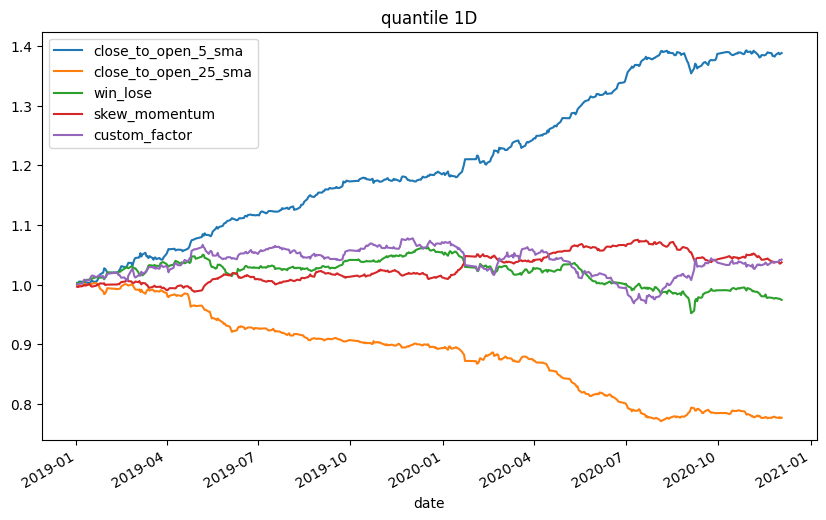

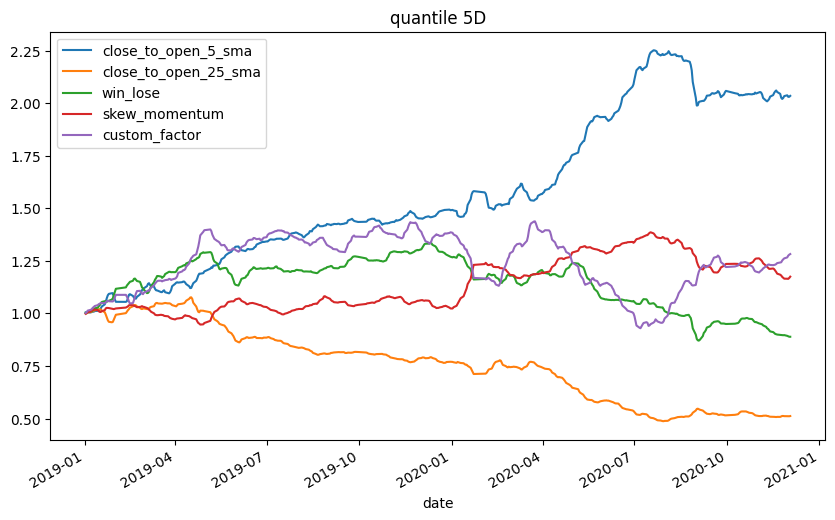

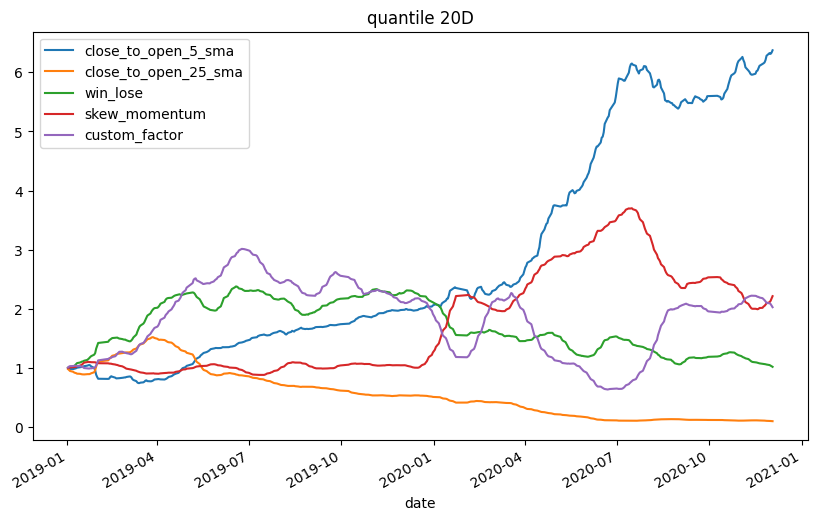

In [20]:
ls_factor_returns_1day = pd.DataFrame()
ls_factor_returns_5day = pd.DataFrame()
ls_factor_returns_20day = pd.DataFrame()
for factor, factor_data in clean_factor_data.items():
    al_factor_returns = al.performance.factor_returns(factor_data)
    ls_factor_returns_1day[factor] = al_factor_returns.iloc[:, 0]
    ls_factor_returns_5day[factor] = al_factor_returns.iloc[:, 1]
    ls_factor_returns_20day[factor] = al_factor_returns.iloc[:, 2]

(1+ls_factor_returns_1day).cumprod().plot(title='quantile 1D')
(1+ls_factor_returns_5day).cumprod().plot(title='quantile 5D')
(1+ls_factor_returns_20day).cumprod().plot(title='quantile 20D')

A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

array([[<AxesSubplot:title={'center':'close_to_open_5_sma'}, xlabel='factor_quantile'>,
        <AxesSubplot:title={'center':'close_to_open_25_sma'}, xlabel='factor_quantile'>],
       [<AxesSubplot:title={'center':'win_lose'}, xlabel='factor_quantile'>,
        <AxesSubplot:title={'center':'skew_momentum'}, xlabel='factor_quantile'>],
       [<AxesSubplot:title={'center':'custom_factor'}, xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>]], dtype=object)

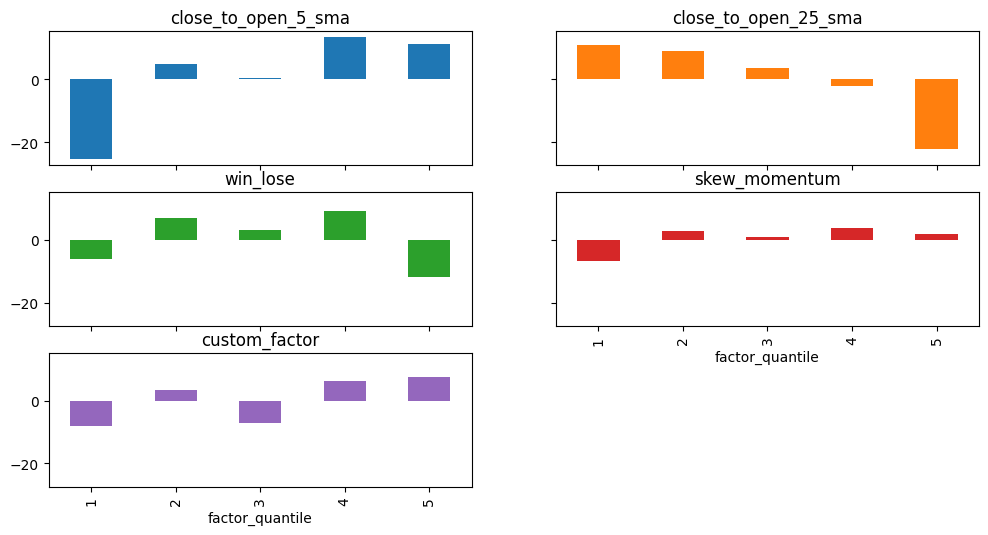

In [21]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 1]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(12, 8),
    legend=False)

### Sharpe Ratio of the Alphas
Implement sharpe_ratio to calculate the sharpe ratio of factor returns.

In [22]:
def sharpe_ratio(factor_returns):
    """
    Get the sharpe ratio for each factor for the entire period
    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor
    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    annualization_factor = np.sqrt(252)
    return factor_returns.mean()/factor_returns.std()*annualization_factor

In [23]:
sharpe_ratio(ls_factor_returns_1day).round(2)

close_to_open_5_sma     4.93
close_to_open_25_sma   -3.63
win_lose               -0.32
skew_momentum           0.66
custom_factor           0.44
dtype: float64

In [24]:
print(sharpe_ratio(ls_factor_returns_5day).round(2))

close_to_open_5_sma     4.30
close_to_open_25_sma   -4.15
win_lose               -0.62
skew_momentum           1.20
custom_factor           1.16
dtype: float64


In [25]:
print(sharpe_ratio(ls_factor_returns_20day).round(2))

close_to_open_5_sma     5.71
close_to_open_25_sma   -6.80
win_lose                0.14
skew_momentum           2.57
custom_factor           1.49
dtype: float64


### Package Analysis
Let's look at analysis of my custom factor and overnight sma 25 factor

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -1.686855 -1.000000 -1.323712  0.198972  51239  22.157405
2               -1.006231 -0.292770 -0.649070  0.210567  43087  18.632216
3               -0.335410  0.292770  0.004464  0.144130  45451  19.654486
4                0.267261  1.000000  0.693690  0.223586  47527  20.552216
5                1.006231  1.686855  1.356691  0.173404  43946  19.003676

Returns Analysis


1D     5D    20D
Ann. alpha                                     0.043  0.041  0.023
beta                                          -0.068 -0.048 -0.005
Mean Period Wise Return Top Quantile (bps)     1.560  1.520  1.492
Mean Period Wise Return Bottom Quantile (bps) -0.736 -1.640 -1.033
Mean Period Wise Spread (bps)                  2.296  3.175  2.512

<Figure size 1000x600 with 0 Axes>

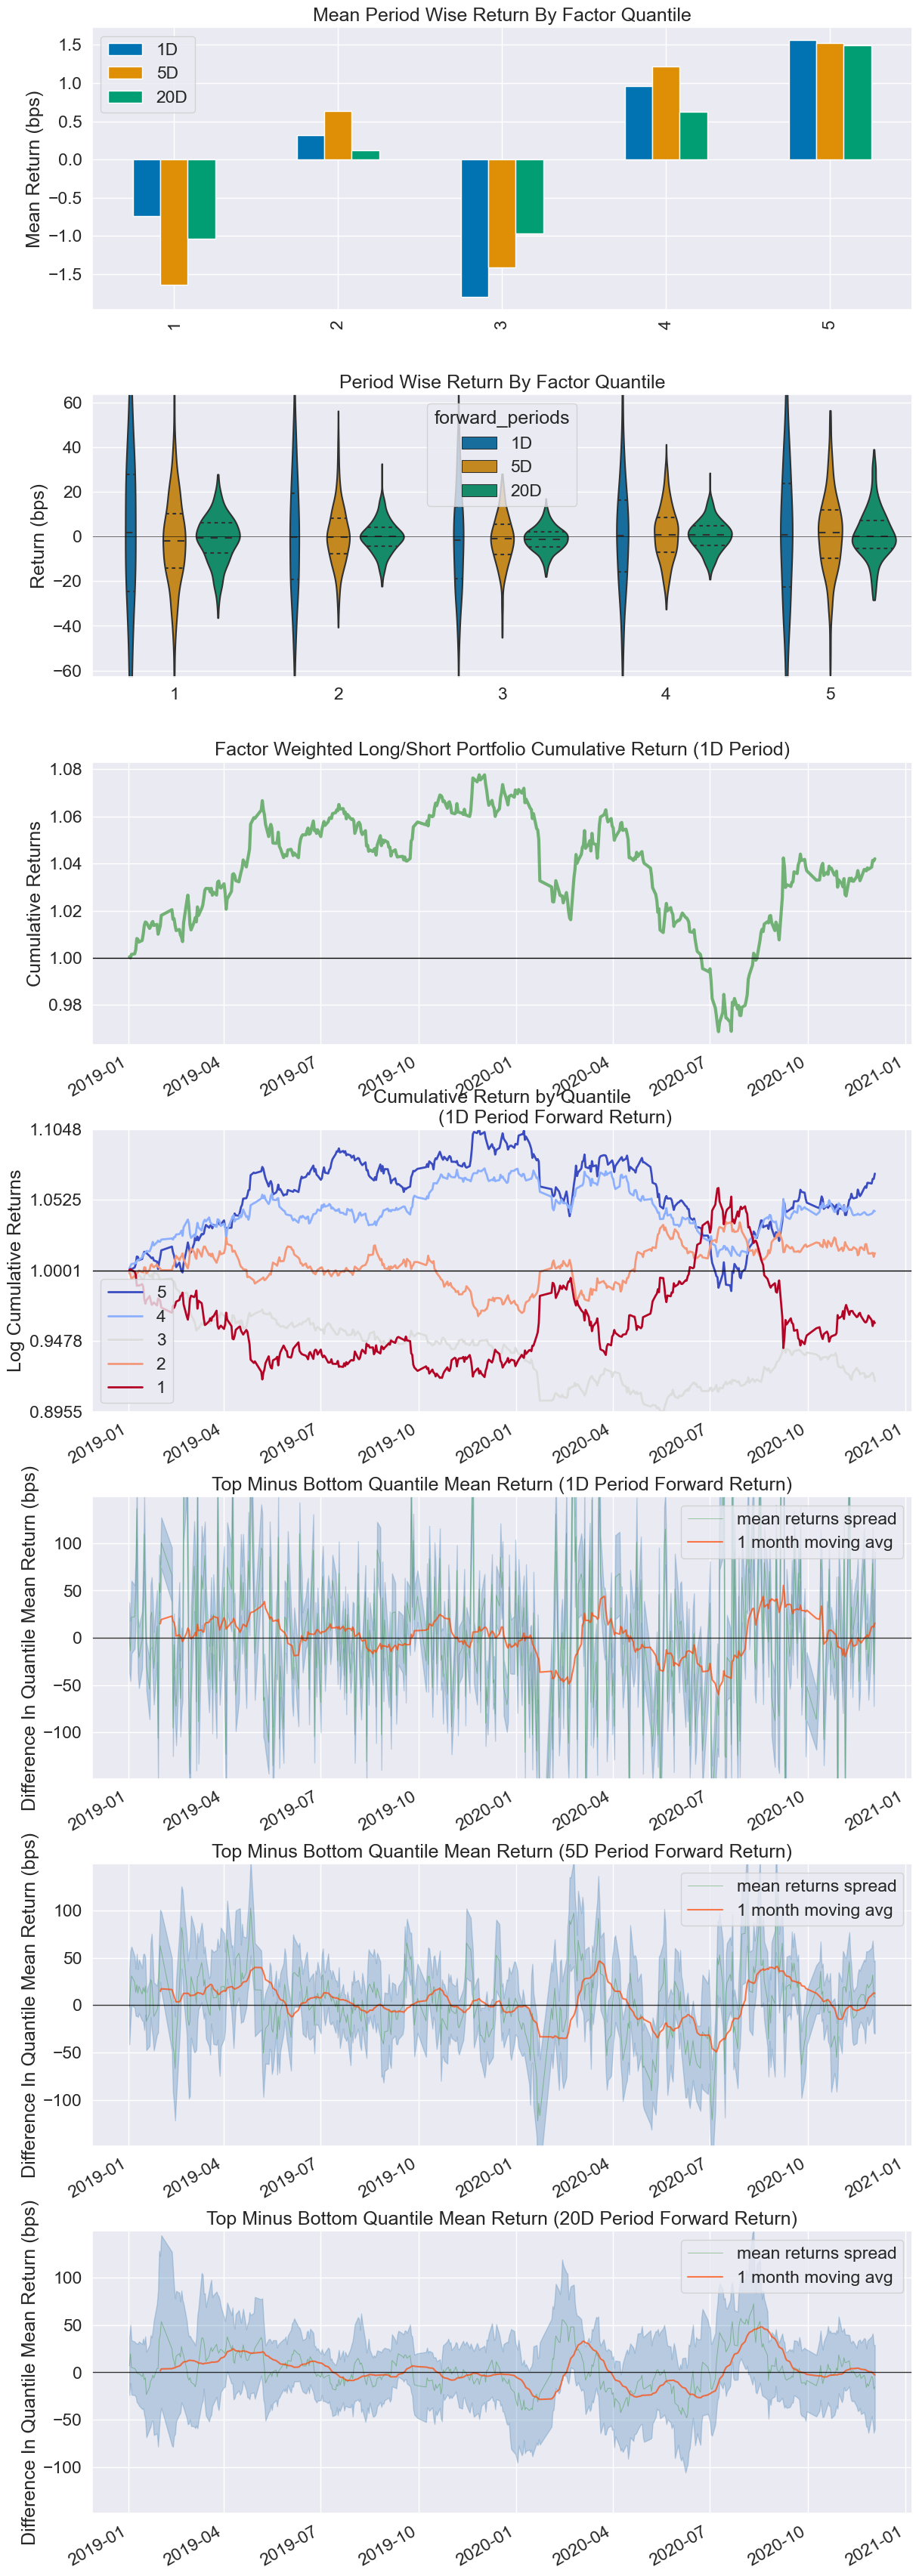

Information Analysis


1D     5D    20D
IC Mean           0.028  0.036  0.037
IC Std.           0.105  0.107  0.115
Risk-Adjusted IC  0.267  0.332  0.322
t-stat(IC)        5.778  7.179  6.965
p-value(IC)       0.000  0.000  0.000
IC Skew          -0.060  0.078  0.022
IC Kurtosis       0.296 -0.274 -0.453

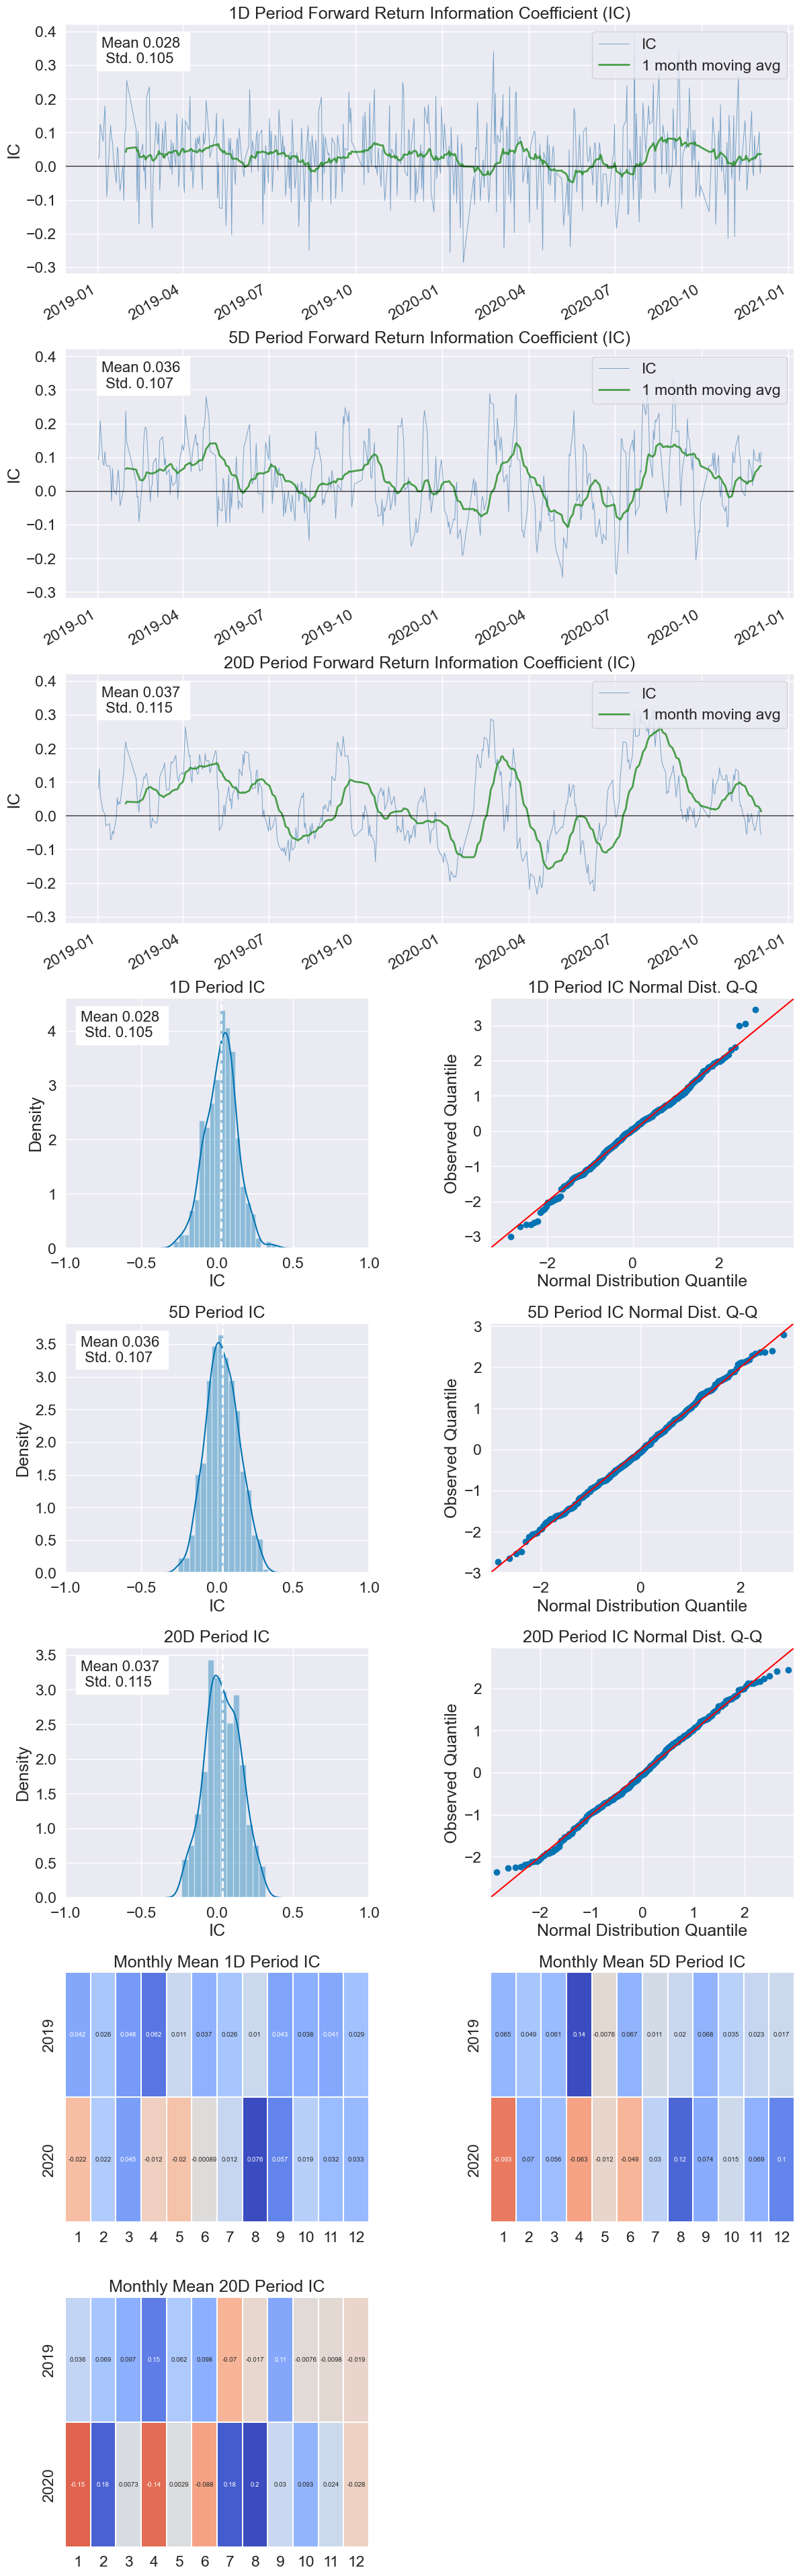

Turnover Analysis


1D     5D    20D
Quantile 1 Mean Turnover   0.144  0.331  0.520
Quantile 2 Mean Turnover   0.321  0.572  0.698
Quantile 3 Mean Turnover   0.331  0.528  0.601
Quantile 4 Mean Turnover   0.337  0.547  0.654
Quantile 5 Mean Turnover   0.218  0.459  0.588

1D    5D    20D
Mean Factor Rank Autocorrelation  0.888  0.65  0.415

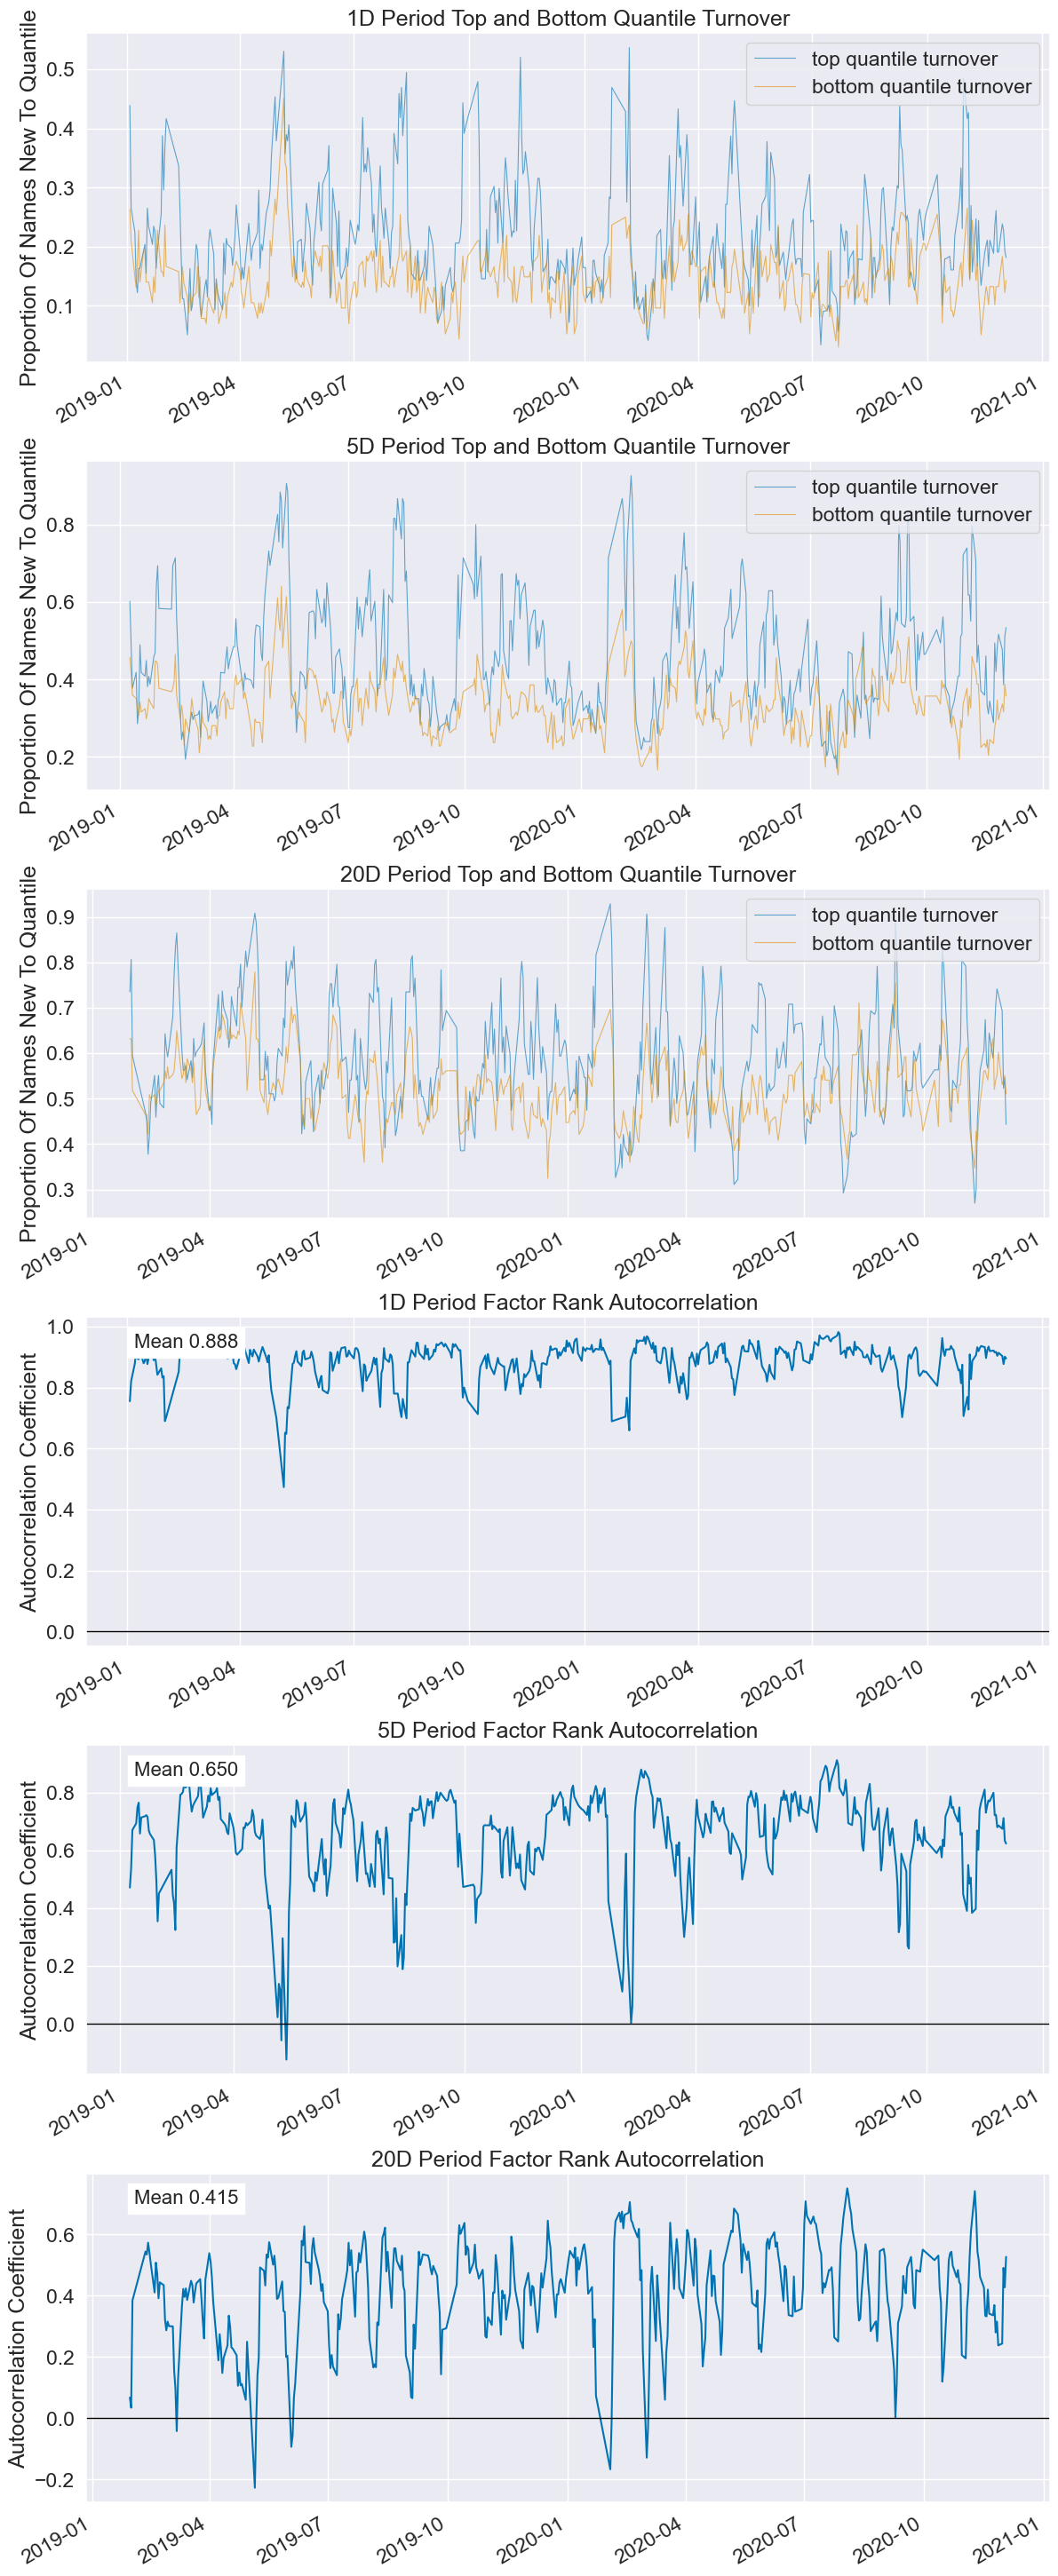

In [28]:
al.tears.create_full_tear_sheet(clean_factor_data['custom_factor'])

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -1.686855 -1.000000 -1.319400  0.201234  51529  22.282811
2               -1.006231 -0.277350 -0.637029  0.210287  42626  18.432865
3               -0.316228  0.335410  0.016624  0.144021  45245  19.565405
4                0.280976  1.009050  0.704594  0.217605  46269  20.008216
5                1.006231  1.686855  1.362809  0.173904  45581  19.710703

Returns Analysis


1D     5D    20D
Ann. alpha                                     -0.131 -0.076 -0.070
beta                                            0.018  0.031  0.045
Mean Period Wise Return Top Quantile (bps)     -7.311 -4.439 -4.168
Mean Period Wise Return Bottom Quantile (bps)   5.525  2.197  1.186
Mean Period Wise Spread (bps)                 -12.835 -6.650 -5.377

<Figure size 1000x600 with 0 Axes>

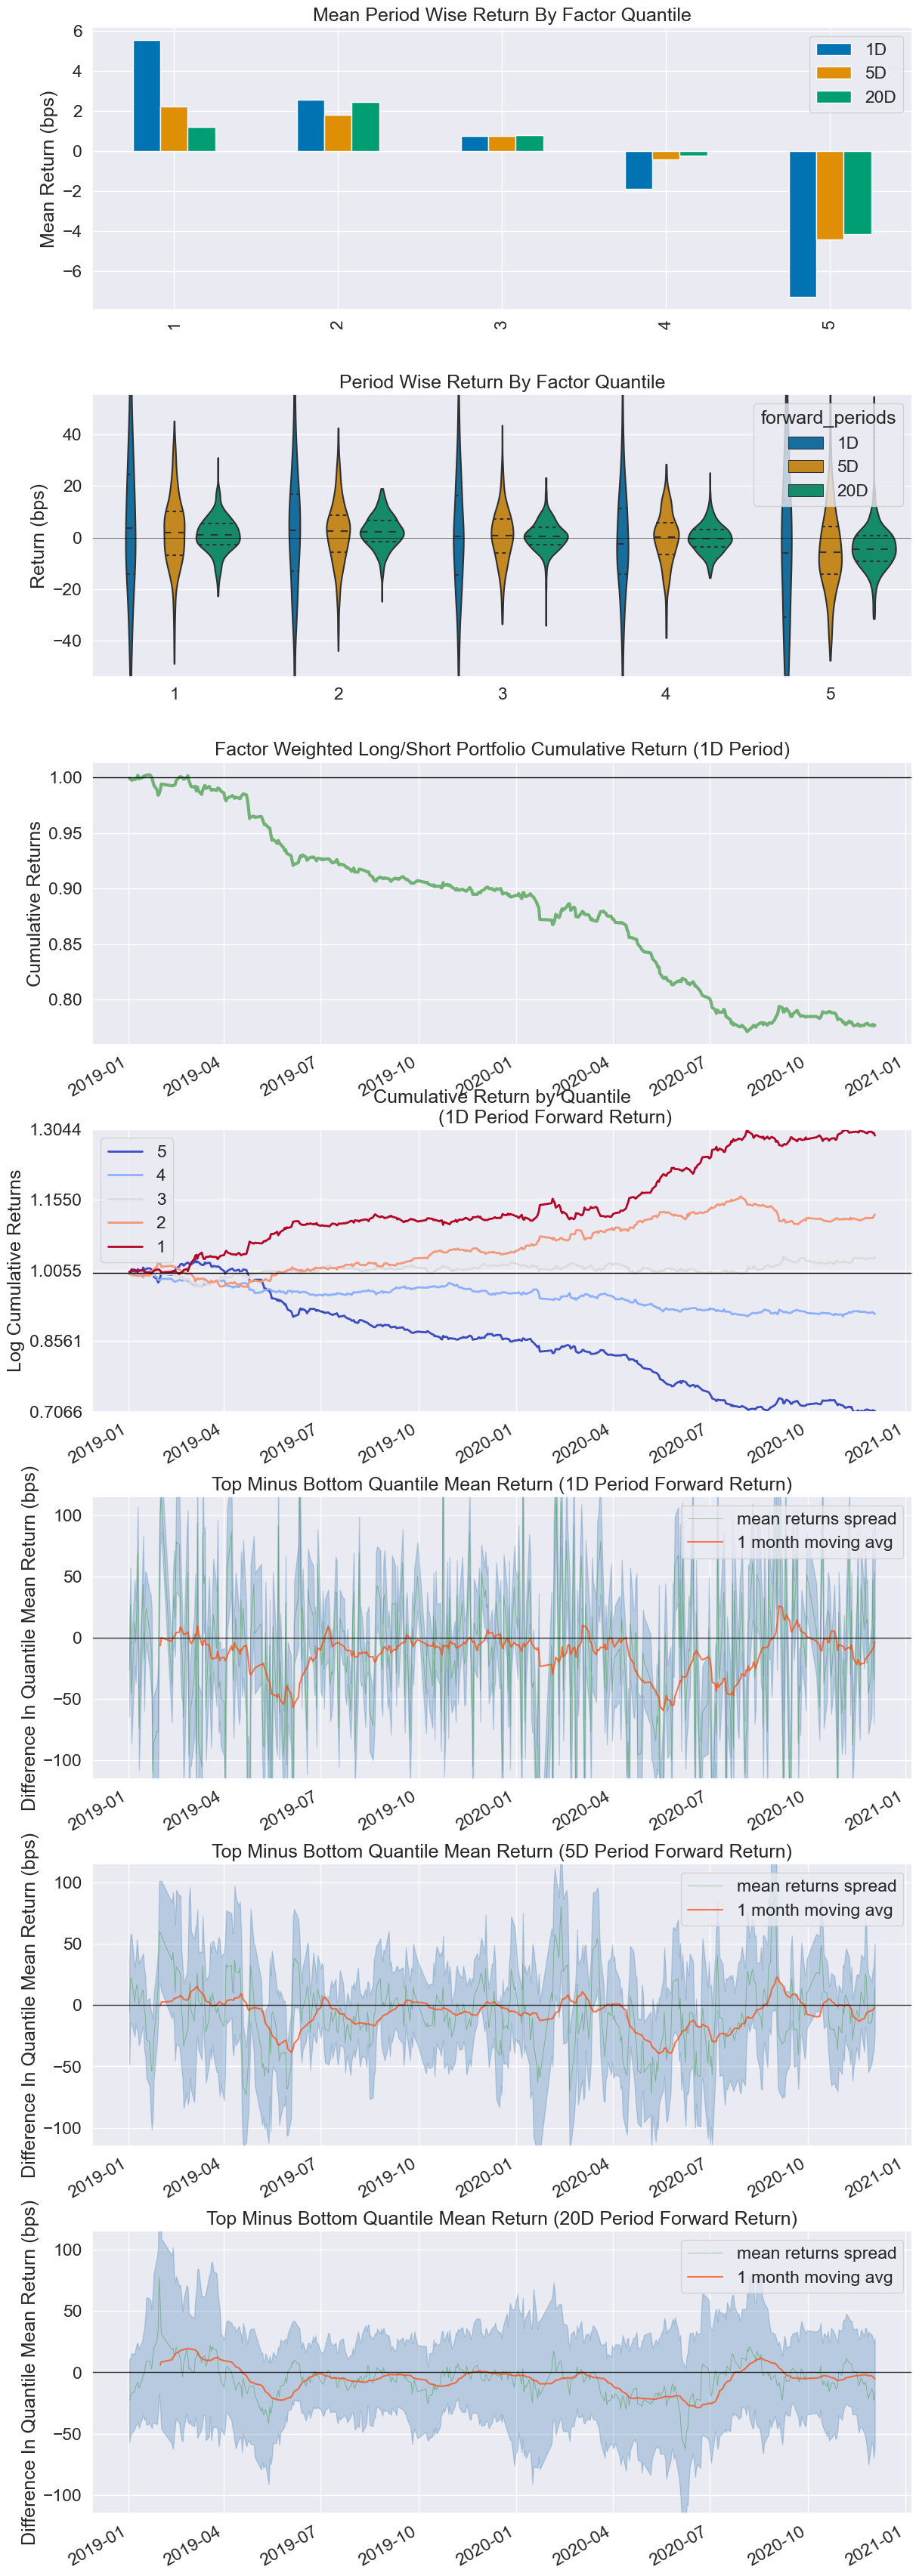

Information Analysis


1D     5D     20D
IC Mean          -0.014 -0.016  -0.034
IC Std.           0.071  0.074   0.069
Risk-Adjusted IC -0.196 -0.212  -0.498
t-stat(IC)       -4.238 -4.592 -10.765
p-value(IC)       0.000  0.000   0.000
IC Skew          -0.097  0.073   0.270
IC Kurtosis       0.192  0.210   0.229

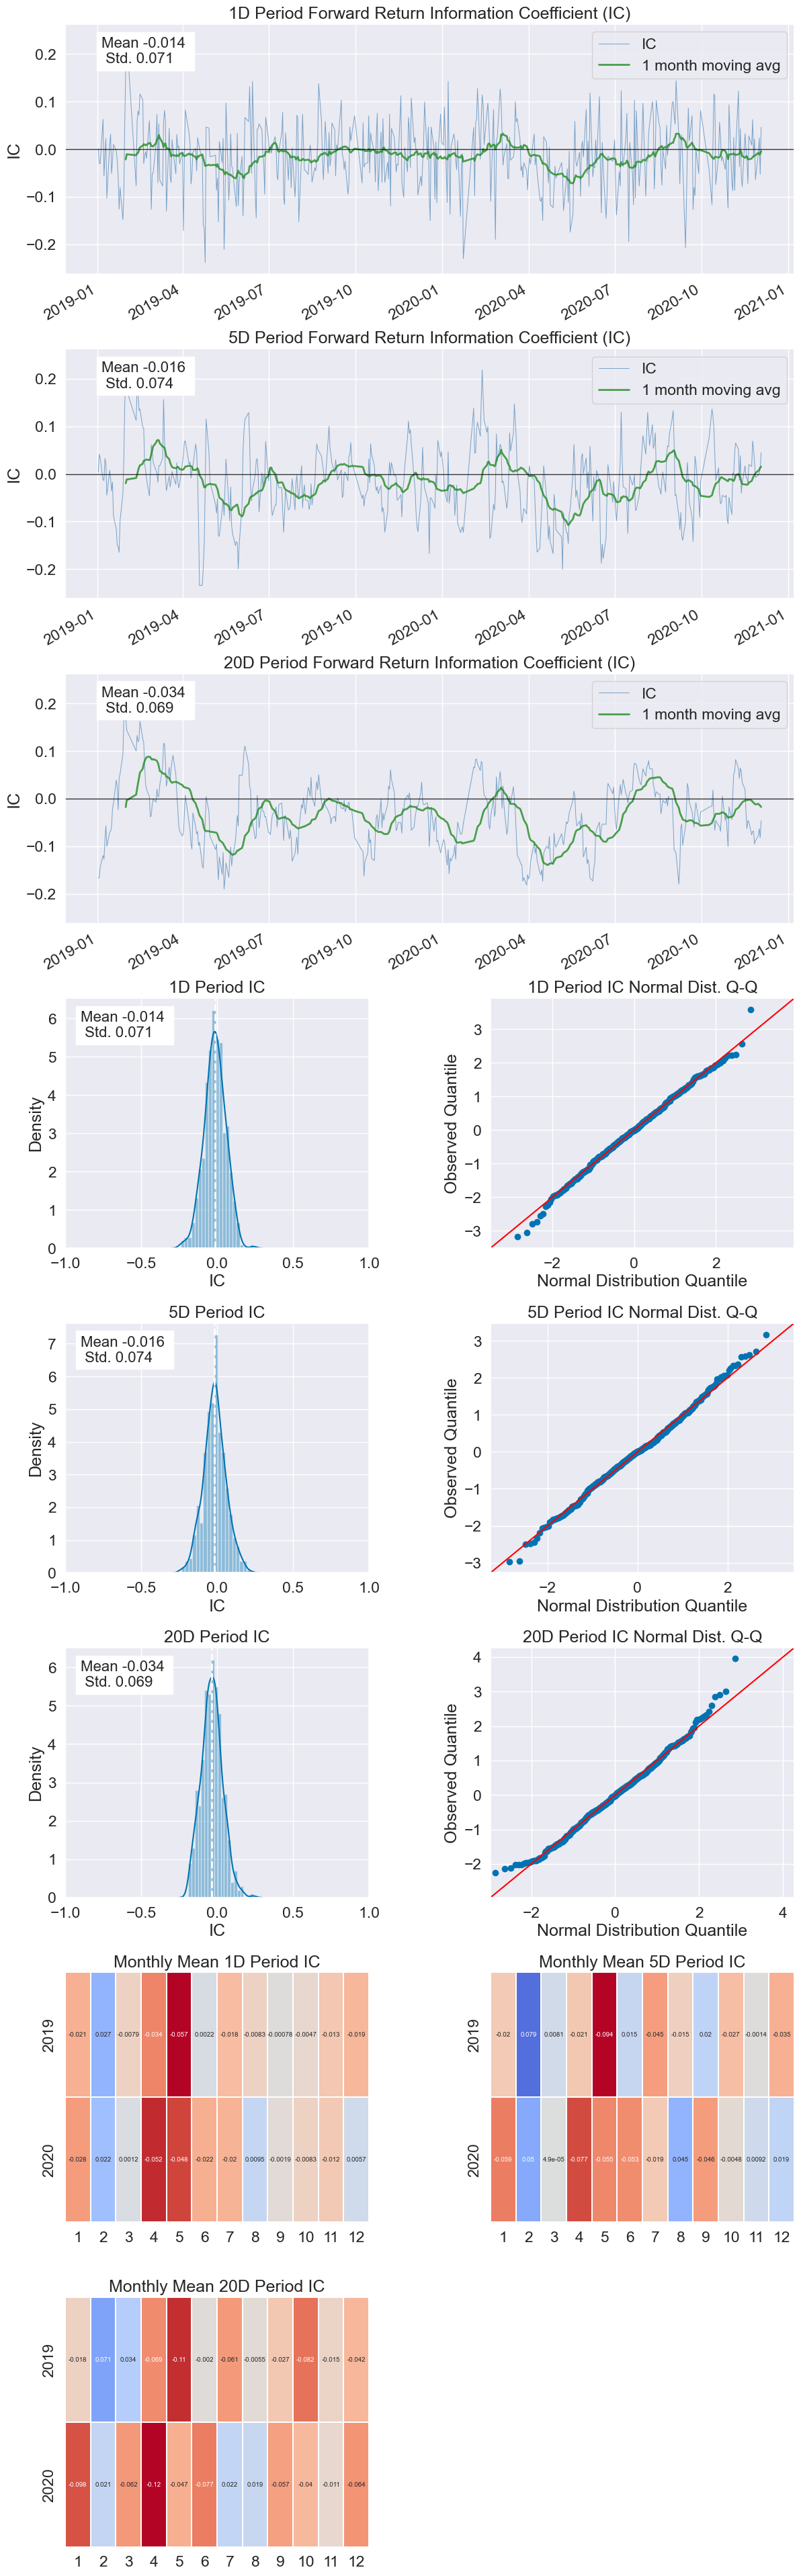

Turnover Analysis


1D     5D    20D
Quantile 1 Mean Turnover   0.127  0.300  0.608
Quantile 2 Mean Turnover   0.277  0.515  0.708
Quantile 3 Mean Turnover   0.273  0.474  0.610
Quantile 4 Mean Turnover   0.251  0.476  0.678
Quantile 5 Mean Turnover   0.125  0.291  0.579

1D     5D    20D
Mean Factor Rank Autocorrelation  0.929  0.762  0.316

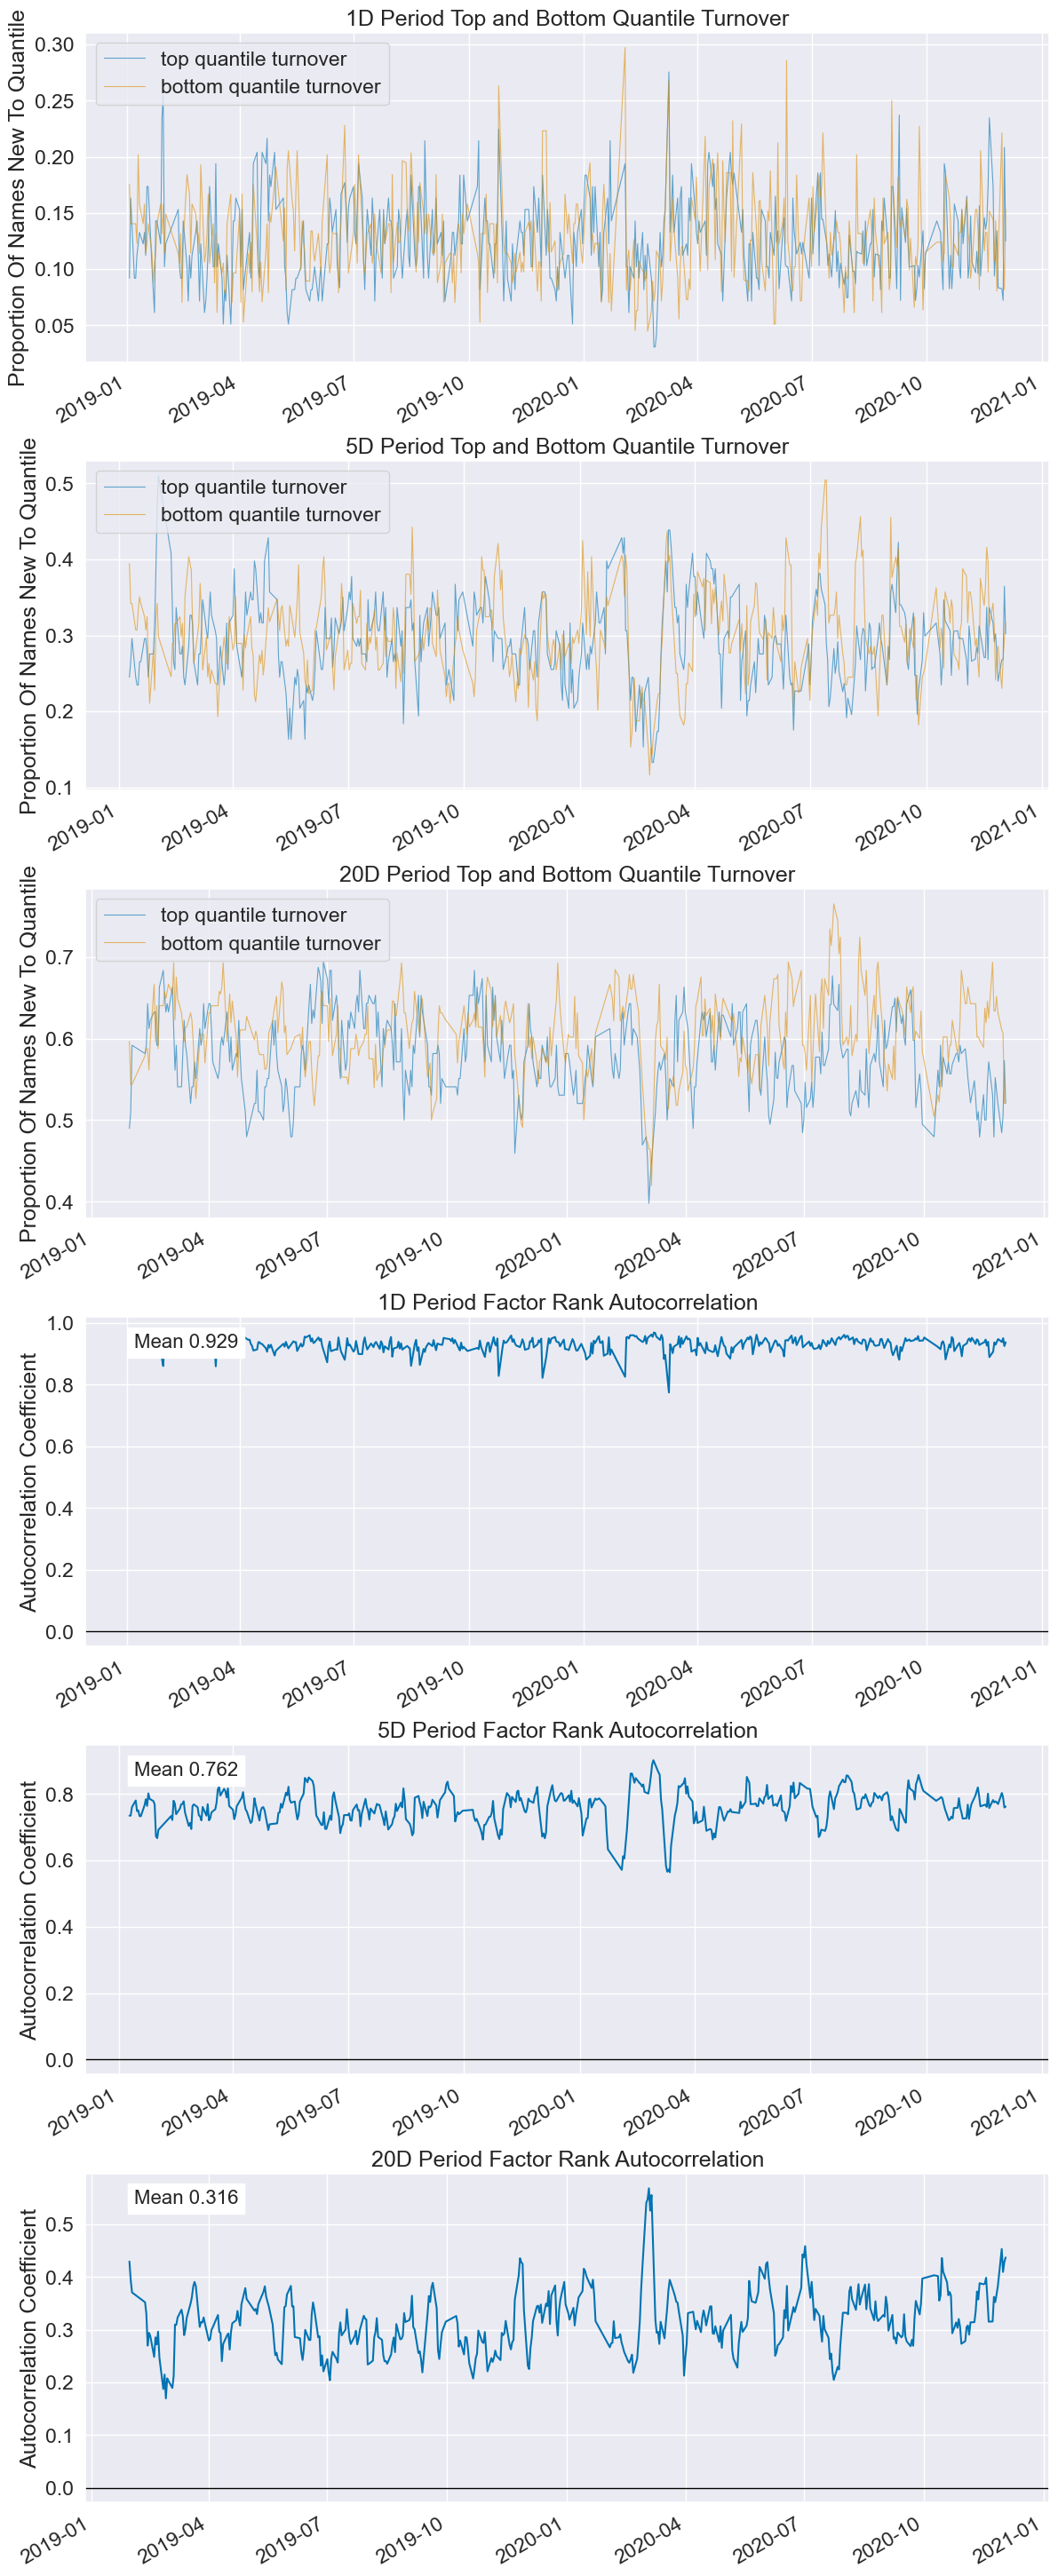

In [27]:
al.tears.create_full_tear_sheet(clean_factor_data['close_to_open_25_sma'])

# Optimal Portfolio

###  Combined Alpha Vector
To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. 
This is a area where machine learning can be very helpful. 
In this module, however, we will take the simplest approach of combination: 

\['close_to_open_5_sma', 'close_to_open_25_sma', 'win_lose', 'skew_momentum', 'custom_factor'\].

\[0.4, 0.4, 0.1, 0, 0.1\]

In [31]:
selected_factors = all_factor_df.columns[[0, 1, 2, 3, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))
# all_factor_df['alpha_vector'] = all_factor_df[selected_factors].mean(axis=1)
all_factor_df['alpha_vector'] = all_factor_df[selected_factors].dot(np.array([0.4,0.4,0.1,0,0.1]).T)
alphas = all_factor_df[['alpha_vector']]
alpha_vector = alphas.loc[all_factor_df.index.get_level_values(0)[-1]]
alpha_vector

Selected Factors: close_to_open_5_sma, close_to_open_25_sma, win_lose, skew_momentum, custom_factor


alpha_vector
asset                  
000008.SZ      0.200000
000009.SZ     -0.534680
000012.SZ      0.200000
000016.SZ      0.000000
000021.SZ     -0.694879
...                 ...
603000.SH     -0.433861
603019.SH      0.026726
603077.SH      0.216930
603128.SH      0.636396
603323.SH      0.244949

[486 rows x 1 columns]

### optimization nomal method
So far we have an alpha model and a risk model. 
I need to optimize portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. We also use covex optimization method. Check `optimizer_helper.py` feel free.

constraint contains risk cap, factor exposure, weight sum and weight range

minize destination is - alpha * weights


In [32]:
from helper.optimizer_helper import OptimalHoldings
'''
View Data
With the OptimalHoldings class implemented, let's see the weights it generates.
It put most of the weight in a few stocks.
'''
optimal_weights = OptimalHoldings().find(alpha_vector, rm.factor_betas_,
                                         rm.factor_cov_matrix_, rm.idiosyncratic_var_vector)
print(max(optimal_weights.values), min(optimal_weights.values))

486
[0.00234498] [-0.00378232]


<AxesSubplot:xlabel='asset'>

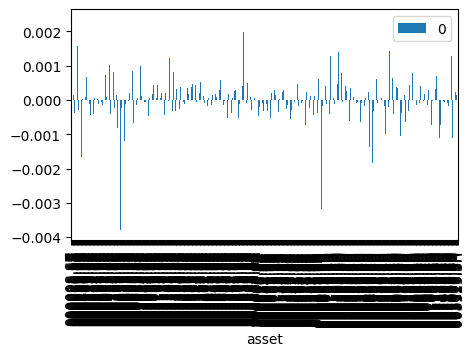

In [46]:
optimal_weights.plot.bar()
# factor exposure distribution
#risk_betas = rm.factor_betas_.loc[optimal_weights.index].T.dot(optimal_weights)
#risk_betas.plot.bar(title='Portfolio Net Factor Exposures',legend=False)

### Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. 
We'll create a new class called OptimalHoldingsRegualization which gets its constraints from the OptimalHoldings class.

In this new class, implement the _get_obj function to return a CVXPY objective 

function that maximize  $\alpha^T * x + \lambda\|x\|^2$ 

where  x  is the portfolio weights,  $\alpha$  is the alpha vector, and  $\lambda$ is the regularization parameter.

In [37]:
from helper.optimizer_helper import OptimalHoldingsRegualization

optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0)\
    .find(alpha_vector, rm.factor_betas_, rm.factor_cov_matrix_, rm.idiosyncratic_var_vector)
print(max(optimal_weights.values), min(optimal_weights.values))

486
[0.00234498] [-0.00378232]
<class 'pandas.core.frame.DataFrame'>


<AxesSubplot:xlabel='asset'>

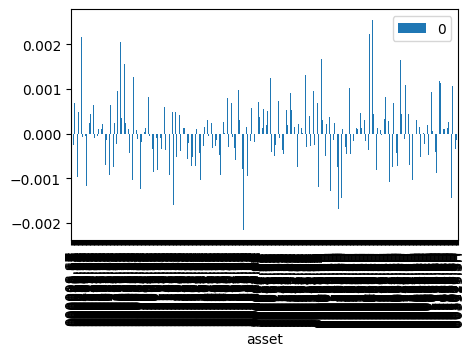

In [44]:
optimal_weights_1.plot.bar()

### Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$
(e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. 
For this next class, OptimalHoldingsStrictFactor, we will implement the _get_obj function to minimize on  $\|x - x^*\|^2$, 
where  x  is the portfolio weights  $x^*$  is the target weighting.

In [48]:
from helper.optimizer_helper import OptimalHoldingsStrictFactor

optimal_weights_2 = OptimalHoldingsStrictFactor()\
    .find(alpha_vector, rm.factor_betas_, rm.factor_cov_matrix_, rm.idiosyncratic_var_vector)
optimal_weights_2

486


0
asset              
000008.SZ  0.000433
000009.SZ -0.000582
000012.SZ  0.000373
000016.SZ  0.000157
000021.SZ -0.000413
...             ...
603000.SH -0.000348
603019.SH  0.000258
603077.SH  0.000121
603128.SH  0.000551
603323.SH  0.000640

[486 rows x 1 columns]

<AxesSubplot:xlabel='asset'>

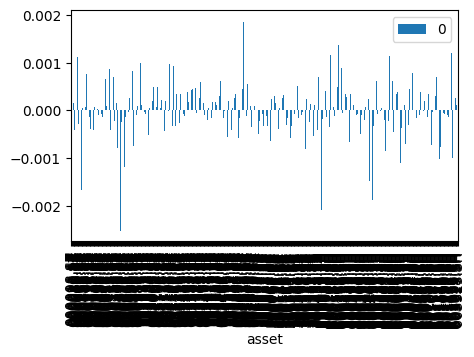

In [49]:
optimal_weights_2.plot.bar()